<a href="https://colab.research.google.com/github/Jlokkerbol/masterclass/blob/main/Multicollinearity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multicollinearity

This notebook covers the specific topic of multicollinearity by considering the effect it can have on the performance of your machine learning model, and how caret, along with so-called recipes, provide a way to deal with multicollinearity.

In [1]:
install.packages('mlbench')
install.packages('caret')
install.packages('glmnet')
install.packages('recipes')
install.packages('dplyr')
install.packages('e1071')
install.packages('corrplot')

library(mlbench)
library(caret)
library(glmnet)
library(recipes)
library(dplyr)
library(e1071)
library(corrplot)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘iterators’, ‘data.table’, ‘gower’, ‘ipred’, ‘timeDate’, ‘foreach’, ‘plyr’, ‘ModelMetrics’, ‘reshape2’, ‘recipes’, ‘pROC’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘shape’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: lattice

Loading required package: ggplot2

Loading required package: Matrix

Loaded glmnet 4.0-2

Loading required package: dplyr


Attaching package: ‘

## Loading the data

We make use of the Sonar dataset, which has 60 predictors available for classifying objects as either Rock (R) or Mine (M)

In [24]:
data(Sonar)
str(Sonar)
df <- Sonar
x <- df[,1:60]
y <- df[,61]

'data.frame':	208 obs. of  61 variables:
 $ V1   : num  0.02 0.0453 0.0262 0.01 0.0762 0.0286 0.0317 0.0519 0.0223 0.0164 ...
 $ V2   : num  0.0371 0.0523 0.0582 0.0171 0.0666 0.0453 0.0956 0.0548 0.0375 0.0173 ...
 $ V3   : num  0.0428 0.0843 0.1099 0.0623 0.0481 ...
 $ V4   : num  0.0207 0.0689 0.1083 0.0205 0.0394 ...
 $ V5   : num  0.0954 0.1183 0.0974 0.0205 0.059 ...
 $ V6   : num  0.0986 0.2583 0.228 0.0368 0.0649 ...
 $ V7   : num  0.154 0.216 0.243 0.11 0.121 ...
 $ V8   : num  0.16 0.348 0.377 0.128 0.247 ...
 $ V9   : num  0.3109 0.3337 0.5598 0.0598 0.3564 ...
 $ V10  : num  0.211 0.287 0.619 0.126 0.446 ...
 $ V11  : num  0.1609 0.4918 0.6333 0.0881 0.4152 ...
 $ V12  : num  0.158 0.655 0.706 0.199 0.395 ...
 $ V13  : num  0.2238 0.6919 0.5544 0.0184 0.4256 ...
 $ V14  : num  0.0645 0.7797 0.532 0.2261 0.4135 ...
 $ V15  : num  0.066 0.746 0.648 0.173 0.453 ...
 $ V16  : num  0.227 0.944 0.693 0.213 0.533 ...
 $ V17  : num  0.31 1 0.6759 0.0693 0.7306 ...
 $ V18  : num  0.

## Data splitting

As always, we start the machine learning pipeline by splitting the data. We use caret's createDataPartition to ensure that the distribution of our outcome is similar in both the training and the test set. The objects x and y are assigned the predictors and outcomes in the training set, respectively.

In [25]:
set.seed(1234)
trainIndex <- createDataPartition(Sonar$Class, p = .8, 
                                  list = FALSE, 
                                  times = 1)

x <- x[trainIndex,]
y <- y[trainIndex]

##Running a first model

We start off running a LASSO using all predictors. 

In [26]:
fitControl <- trainControl(method = "repeatedcv",
                           number = 5,    # ten folds
                           repeats = 3)    # repeated three times

# train model (LASSO)
lambda <- 10^seq(-3,3,length=100)
set.seed(825)
LassoFit <- train(Class ~ ., data = df[trainIndex,], 
                  method = "glmnet", 
                  trControl = fitControl,
                  tuneGrid = expand.grid(alpha = 1, lambda = lambda))

In [27]:
LassoFit
coef(LassoFit$finalModel, LassoFit$bestTune$lambda)
sum(coef(LassoFit$finalModel, LassoFit$bestTune$lambda)!=0)-1

confusionMatrix(df[-trainIndex,61], predict(LassoFit,newdata = df[-trainIndex,]))

glmnet 

167 samples
 60 predictor
  2 classes: 'M', 'R' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 133, 133, 133, 135, 134, 134, ... 
Resampling results across tuning parameters:

  lambda        Accuracy   Kappa     
  1.000000e-03  0.7245729  0.44271596
  1.149757e-03  0.7224896  0.43870929
  1.321941e-03  0.7205288  0.43484392
  1.519911e-03  0.7226122  0.43861334
  1.747528e-03  0.7186312  0.43073162
  2.009233e-03  0.7227347  0.43911592
  2.310130e-03  0.7187537  0.43088019
  2.656088e-03  0.7226753  0.43899156
  3.053856e-03  0.7267157  0.44723126
  3.511192e-03  0.7267157  0.44723126
  4.037017e-03  0.7267751  0.44709632
  4.641589e-03  0.7227347  0.43955701
  5.336699e-03  0.7207145  0.43524148
  6.135907e-03  0.7145908  0.42303890
  7.054802e-03  0.7204731  0.43494266
  8.111308e-03  0.7164884  0.42666436
  9.326033e-03  0.7125668  0.41957144
  1.072267e-02  0.7166072  0.42804167
  1.232847e-02  0.7186312  0.43242338
 

61 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept)  0.3640621492
V1           .           
V2           .           
V3           .           
V4           .           
V5           .           
V6           .           
V7           .           
V8           .           
V9           .           
V10          .           
V11         -1.5379857260
V12         -0.0001105843
V13          .           
V14          .           
V15          .           
V16          .           
V17          .           
V18          .           
V19          .           
V20          .           
V21          .           
V22          .           
V23          .           
V24          .           
V25          .           
V26          .           
V27          .           
V28          .           
V29          .           
V30          .           
V31          .           
V32          .           
V33          .           
V34          .           
V35          .        

[1] 4

Confusion Matrix and Statistics

          Reference
Prediction  M  R
         M 19  3
         R  7 12
                                         
               Accuracy : 0.7561         
                 95% CI : (0.597, 0.8764)
    No Information Rate : 0.6341         
    P-Value [Acc > NIR] : 0.06935        
                                         
                  Kappa : 0.5024         
                                         
 Mcnemar's Test P-Value : 0.34278        
                                         
            Sensitivity : 0.7308         
            Specificity : 0.8000         
         Pos Pred Value : 0.8636         
         Neg Pred Value : 0.6316         
             Prevalence : 0.6341         
         Detection Rate : 0.4634         
   Detection Prevalence : 0.5366         
      Balanced Accuracy : 0.7654         
                                         
       'Positive' Class : M              
                                         

LASSO selects 4 predictors and arrives at an accuracy of 0.7561 on the test data. 

Let's see if we can improve this performance by addressing multicollinearity among the predictors. To find out which predictors are correlated, we make a correlation plot.

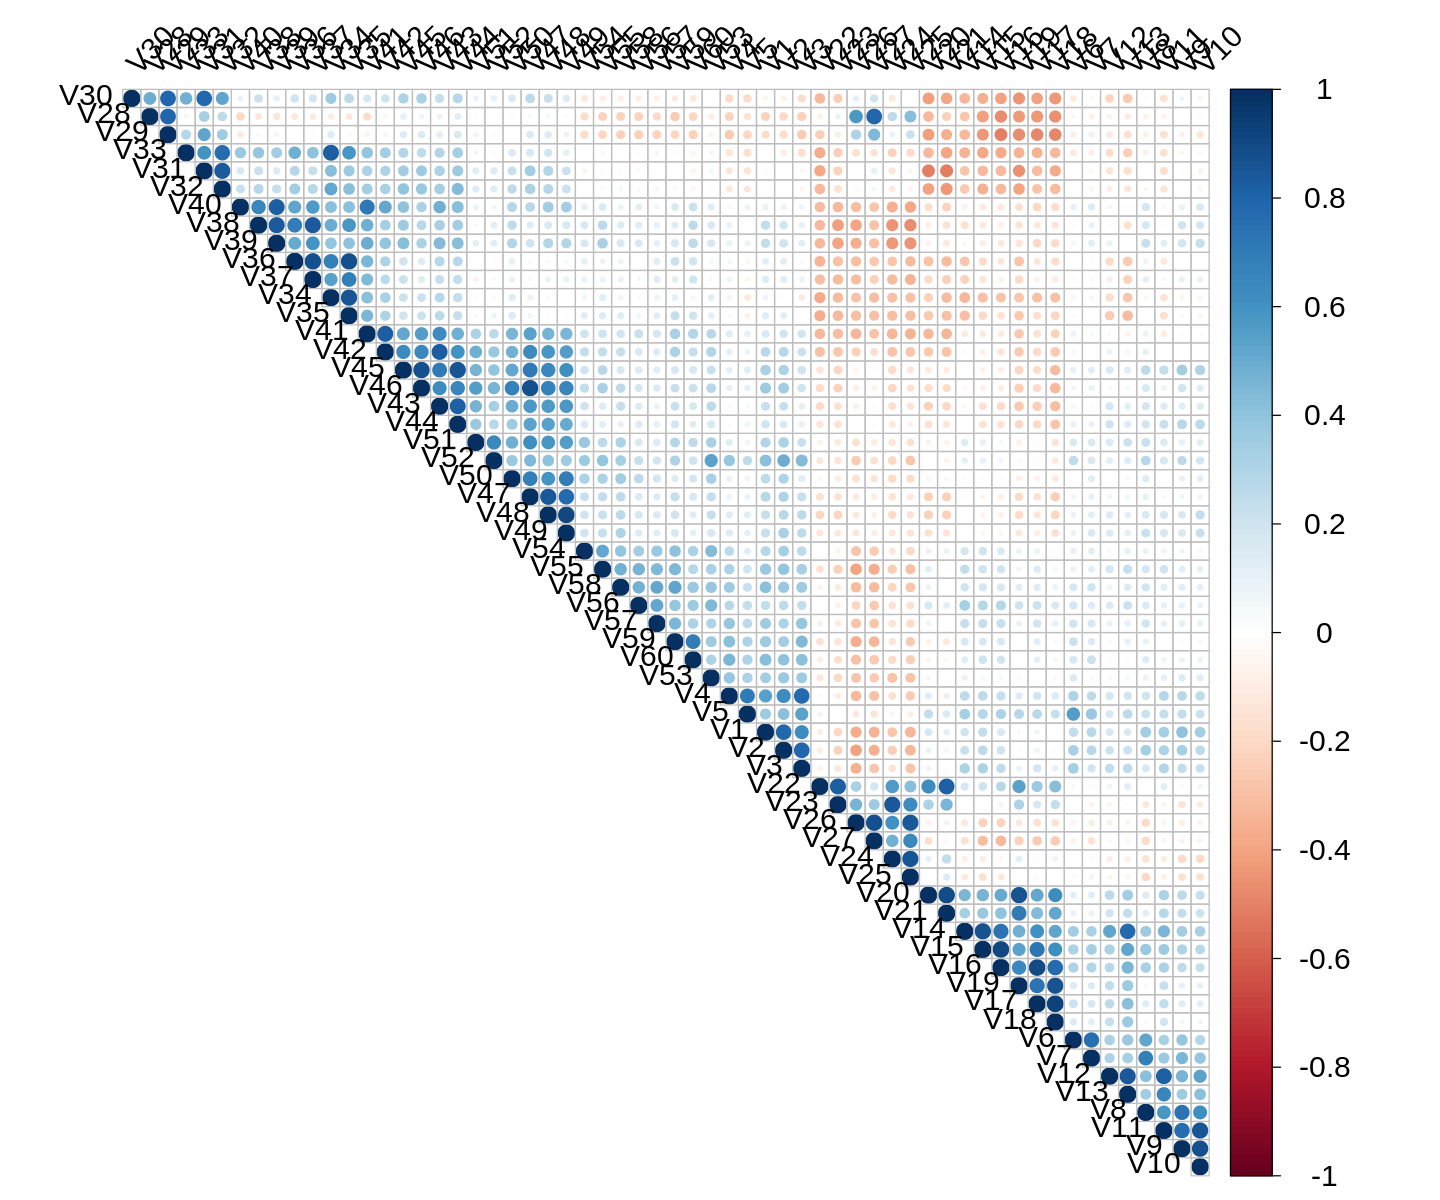

In [28]:
res <- cor(df[trainIndex,1:60])
options(repr.plot.width=12, repr.plot.height=10)
corrplot(res, type = "upper", order = "hclust", 
         tl.col = "black", tl.srt = 45, tl.cex = 1.5, cl.cex = 1.5)


The predictors V41 up to V53 seem to exhibit strong positively correlation. This can be highlighted by making a new correlation plot solely for these predictors. 

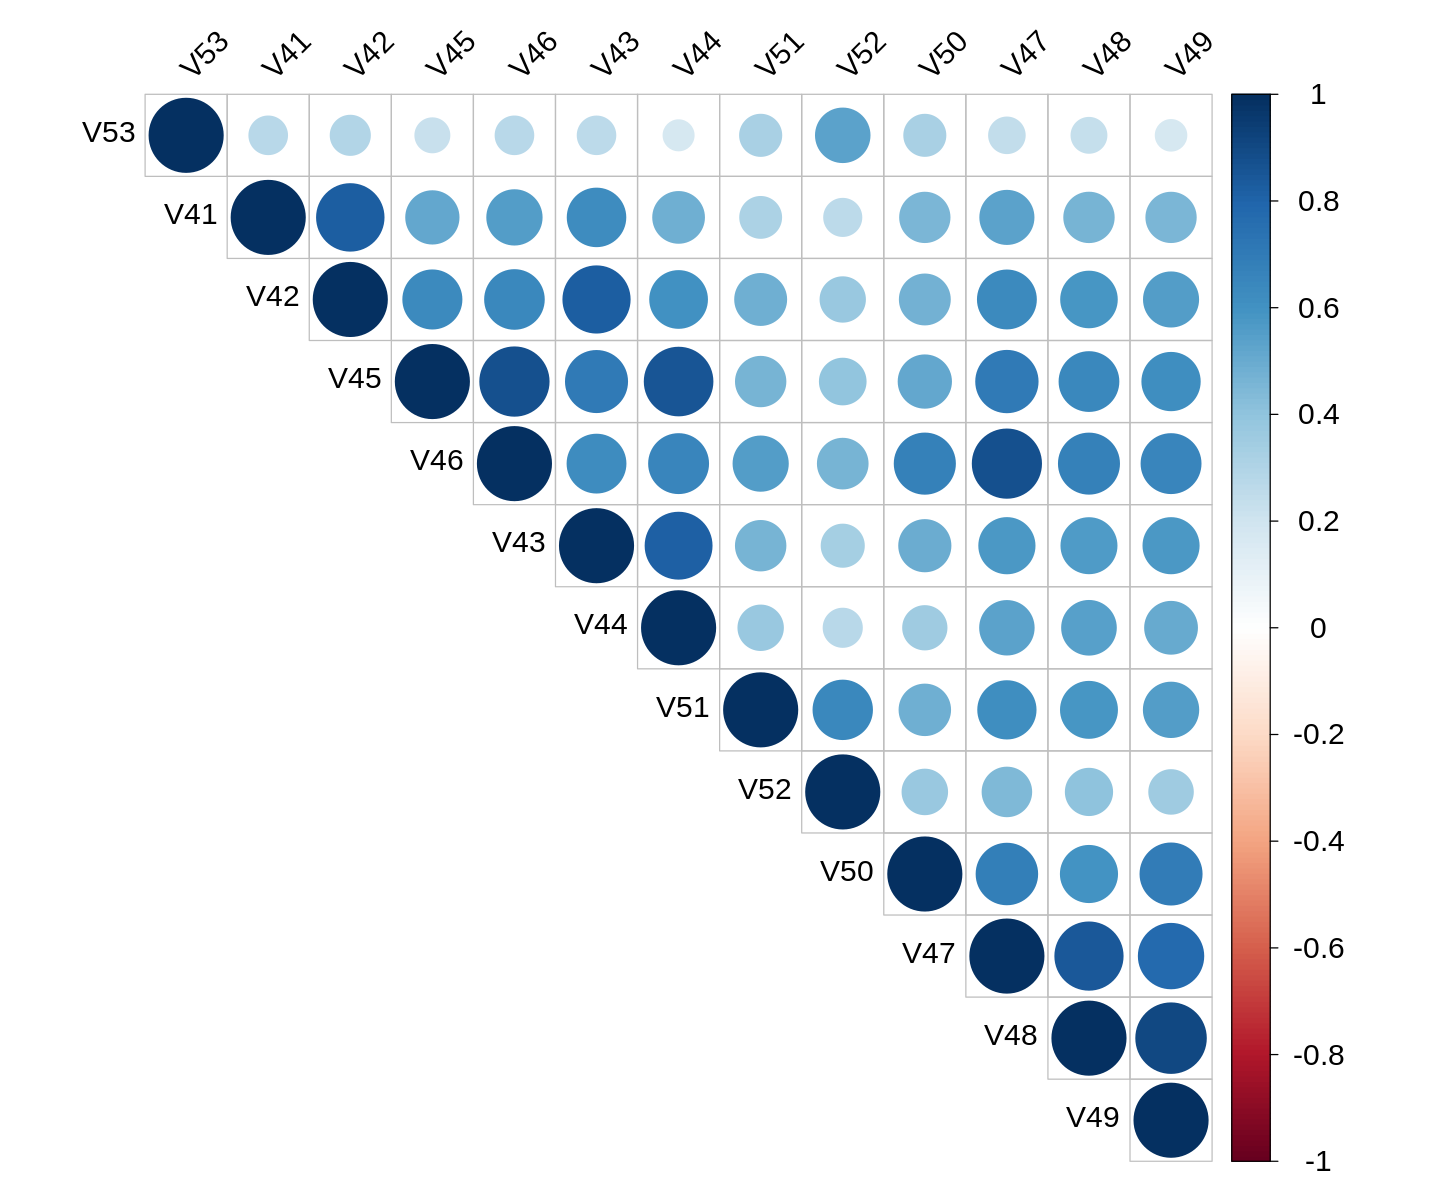

In [29]:
res <- cor(df[trainIndex,41:53])
options(repr.plot.width=12, repr.plot.height=10)
corrplot(res, type = "upper", order = "hclust", 
         tl.col = "black", tl.srt = 45, tl.cex = 1.5, cl.cex = 1.5)

# Running a model while considering multicollinearity

This time, we run a model while adding an additional step where instead of using the 13 correlated predictors, we use five principal components of these 13 predictors, which can be seen as five variables that are constructed using these 13 predictors, that capture most of the information in these 13 predictors, but which are no longer correlated. This allows us to see if this translates into better performance, i.e. if using correlated predictors in your model can hurt model performance.

Changing your predictor data in the way described above is not straightforward, as this should be applied on the data not used for validating your model results, but only on the folds of training data used for training your model. This means that in the case of cross-validation, this becomes tricky as you need to apply this data preparation step to different parts of the data in each iteration of applying cross-validation.

Luckily, caret combined with 'recipes' provides the structure to do exactly that. 

We start off defining a 'recipe' stating that we add in a step in the machine learning pipeline where we take principal components. We first add PCA_ to the predictor names of these variables, such that in the recipe we can easily refer to this group of predictors.


In [30]:
names(df)[41:53] <- paste("PCA_",41:53, sep="")
class_recipe <- recipe(Class~., data = df[trainIndex,]) %>% step_pca(contains("PCA"))

class_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         60

Operations:

No PCA components were extracted.

Then we run our LASSO model like we are used to, except for the fact that we replace the model (Class ~ .) bij class_recipe that we defined in the previous code block.

In [31]:
fitControl <- trainControl(method = "repeatedcv",
                           number = 5,    # ten folds
                           repeats = 3)    # repeated three times

set.seed(825)
LassoFit_recipe <- train(class_recipe, data = df[trainIndex,],
                  method = "glmnet", 
                  trControl = fitControl,
                  tuneGrid = expand.grid(alpha = 1, lambda = lambda))

Warning message:
“from glmnet Fortran code (error code -99); Convergence for 99th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”


And then we can evaluate the results, where we see in the list of coefficients that V41 - V53 are no longer used in the model, and that instead PC1 - PC5 are added. The model below uses 8 instead of 4 predictors, and returns an accuracy of 0.8537 on the test set instead, higher than the 0.7561 we found using all the predictors.

In [32]:
LassoFit_recipe
coef(LassoFit_recipe$finalModel, LassoFit_recipe$bestTune$lambda)
sum(coef(LassoFit_recipe$finalModel, LassoFit_recipe$bestTune$lambda)!=0)-1

confusionMatrix(df[-trainIndex,61], predict(LassoFit_recipe,newdata = df[-trainIndex,]))

glmnet 

167 samples
 60 predictor
  2 classes: 'M', 'R' 

Recipe steps: pca 
Resampling: Cross-Validated (5 fold, repeated 3 times) 
Summary of sample sizes: 133, 133, 133, 135, 134, 134, ... 
Resampling results across tuning parameters:

  lambda        Accuracy   Kappa    
  1.000000e-03  0.6886809  0.3704676
  1.149757e-03  0.6905229  0.3739251
  1.321941e-03  0.7005051  0.3936093
  1.519911e-03  0.6985443  0.3894936
  1.747528e-03  0.6924837  0.3777023
  2.009233e-03  0.6983660  0.3900789
  2.310130e-03  0.7043709  0.4023177
  2.656088e-03  0.7103721  0.4145681
  3.053856e-03  0.7103721  0.4145681
  3.511192e-03  0.7125111  0.4188988
  4.037017e-03  0.7164290  0.4277982
  4.641589e-03  0.7302733  0.4559026
  5.336699e-03  0.7322341  0.4599612
  6.135907e-03  0.7363376  0.4682712
  7.054802e-03  0.7344363  0.4641572
  8.111308e-03  0.7324755  0.4599811
  9.326033e-03  0.7285539  0.4520834
  1.072267e-02  0.7265337  0.4483209
  1.232847e-02  0.7285539  0.4521540
  1.417474e-02  0.72

53 x 1 sparse Matrix of class "dgCMatrix"
                     1
(Intercept)  1.0725657
V1          -2.2077371
V2           .        
V3           .        
V4          -2.2329757
V5           .        
V6           .        
V7           .        
V8           .        
V9           .        
V10          .        
V11         -2.2646149
V12         -1.2686553
V13          .        
V14          .        
V15          .        
V16          .        
V17          .        
V18          .        
V19          .        
V20          .        
V21          .        
V22         -0.0967216
V23          .        
V24          .        
V25          .        
V26          .        
V27          .        
V28          .        
V29          .        
V30          .        
V31          .        
V32          .        
V33          .        
V34          .        
V35          .        
V36          1.0611264
V37          .        
V38          .        
V39          .        
V40          . 

[1] 8

Confusion Matrix and Statistics

          Reference
Prediction  M  R
         M 17  5
         R  1 18
                                          
               Accuracy : 0.8537          
                 95% CI : (0.7083, 0.9443)
    No Information Rate : 0.561           
    P-Value [Acc > NIR] : 6.6e-05         
                                          
                  Kappa : 0.7099          
                                          
 Mcnemar's Test P-Value : 0.2207          
                                          
            Sensitivity : 0.9444          
            Specificity : 0.7826          
         Pos Pred Value : 0.7727          
         Neg Pred Value : 0.9474          
             Prevalence : 0.4390          
         Detection Rate : 0.4146          
   Detection Prevalence : 0.5366          
      Balanced Accuracy : 0.8635          
                                          
       'Positive' Class : M               
                                    

#To Conclude

Multicollinearity amongst your predictors can harm your model performance. Addressing multicollinearity, for example by using principal component analysis, is not straightforward, but the caret and recipes libraries provide a fairly straightforward way to properly implement this in R.